In [1]:
import torch
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0,'/home/gsoc0/Adversarial_CapsNet_Pytorch/')

from model.cnn_net import *
from utils.training import *
from data.data import *

In [2]:
base_path = '/home/gsoc0/Adversarial_CapsNet_Pytorch/'
model_path = os.path.join(base_path, "weights")

args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-5,
    'LEARNING_RATE_2': 1e-5,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusCR',
    
}

#Setting Default Cuda Device
torch.cuda.set_device(1)

In [3]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusCR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

## Loading Dataset

In [4]:
dataloader = {}
dataloader['train'], dataloader['val'] = dataset(args)

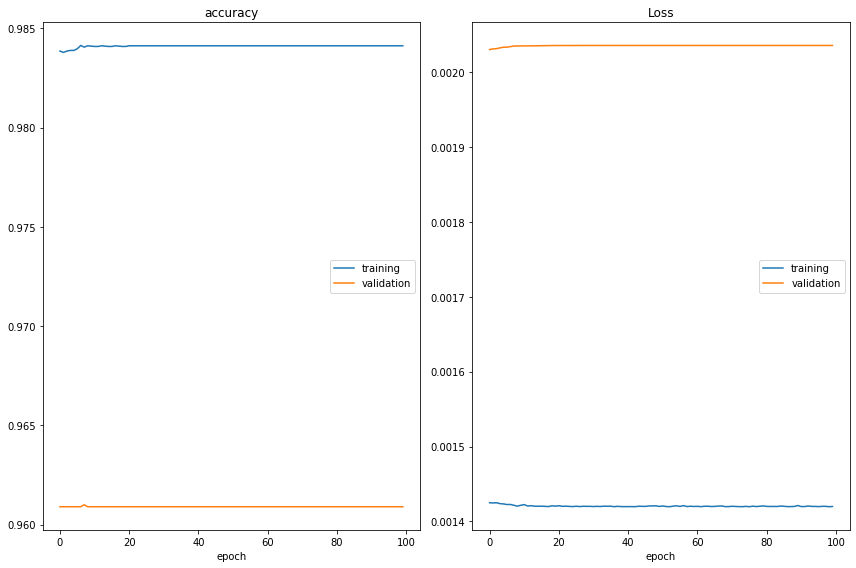

accuracy
	training         	 (min:    0.984, max:    0.984, cur:    0.984)
	validation       	 (min:    0.961, max:    0.961, cur:    0.961)
Loss
	training         	 (min:    0.001, max:    0.001, cur:    0.001)
	validation       	 (min:    0.002, max:    0.002, cur:    0.002)


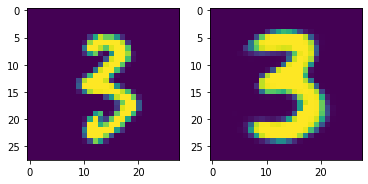

Weights of Reconstruction Layer: tensor([-1.7164e-04, -7.7781e-05, -2.1100e-05], device='cuda:1',
       grad_fn=<AsStridedBackward>)
Grads of Reconstruction Layer: tensor([-3.2791e-09, -2.2030e-09,  8.2801e-09], device='cuda:1')


In [5]:
optimizer = torch.optim.Adam([
                {'params': net.decoder.parameters(), 'lr':args['LEARNING_RATE_2'], 'weight_decay':args['WEIGHTDECAY']},
                {'params': net.conv1.parameters()},
                {'params': net.conv2.parameters()},
                {'params': net.fc1.parameters()},
                {'params': net.fc2.parameters()},
            ], lr=args['LEARNING_RATE_1'])

train_clean(net, optimizer, dataloader, args)

In [12]:
torch.save(net.state_dict(), os.path.join(model_path, "CNNplusCR"+args['DATASET_NAME'] +".pth"))